In [1]:
from dataloaders.pc_dataset import SemanticKITTI
import argparse
import yaml
from easydict import EasyDict
from PIL import Image
from torchvision.transforms import transforms
import numpy as np
from torch.utils.data import DataLoader
from matplotlib import cm

totensor = transforms.ToTensor()
topil = transforms.ToPILImage()

args = argparse.ArgumentParser()
args = args.parse_args(args=[])
with open('./config/semantic.yaml') as stream:
    config = yaml.safe_load(stream)
config.update(vars(args))
args = EasyDict(config)
dataset = SemanticKITTI(args=args)
dataloader = DataLoader(dataset, 1, False)

cmap = cm.get_cmap('viridis')
sm = cm.ScalarMappable(cmap=cmap)
color_range = sm.to_rgba(np.linspace(0,1,256), bytes=True)[:, 0:3]

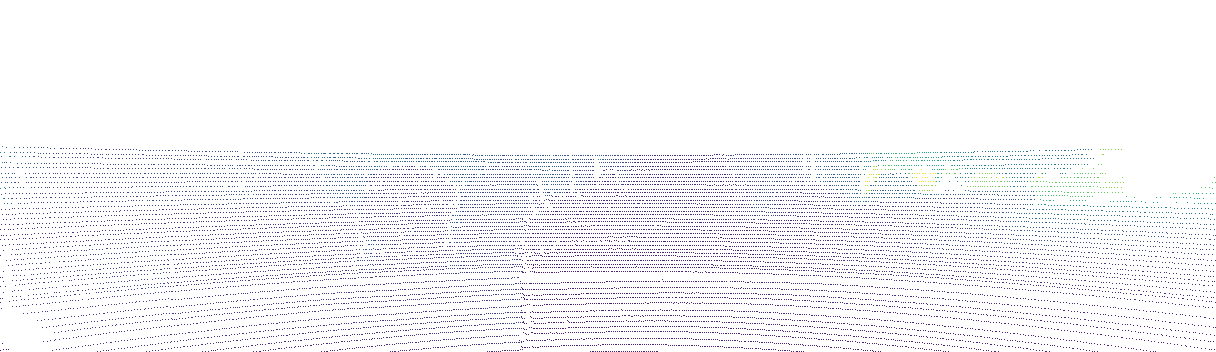

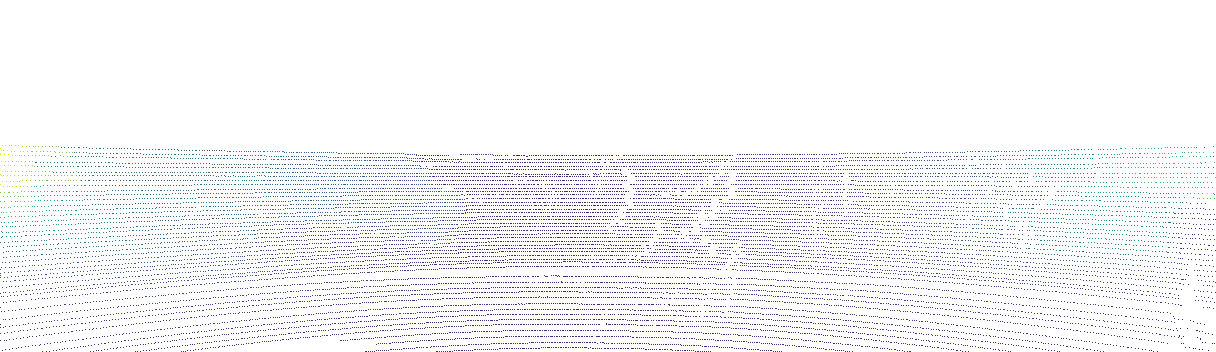

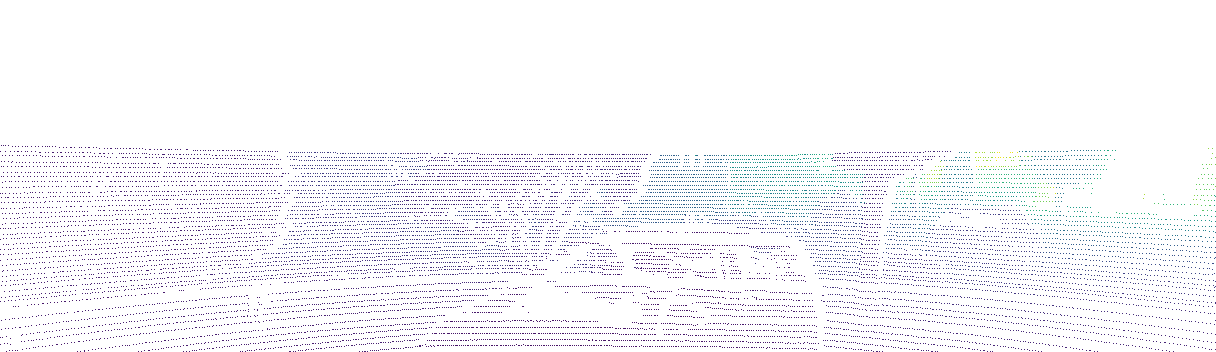

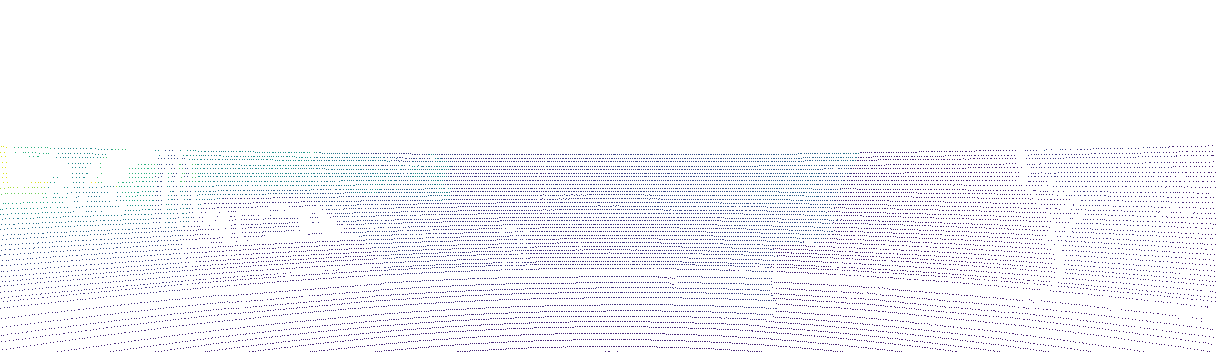

In [2]:
cur_data = next(iter(dataloader))

depth_img0 = (cur_data['velodyne_proj_img0'][0]/cur_data['velodyne_proj_img0'][0].max()*255.).cpu().numpy().squeeze().astype(np.uint8)
depth_rgb0 = color_range[depth_img0].astype(np.uint8)
depth_img0[depth_img0>0]=255
depth_rgb0 = np.concatenate([depth_rgb0, np.expand_dims(depth_img0,-1)], axis=-1)

show_img = Image.fromarray(depth_rgb0)
show_img.show()

depth_img0 = (cur_data['velodyne_proj_img1'][0]/cur_data['velodyne_proj_img1'][0].max()*255.).cpu().numpy().squeeze().astype(np.uint8)
depth_rgb0 = color_range[depth_img0].astype(np.uint8)
depth_img0[depth_img0>0]=255
depth_rgb0 = np.concatenate([depth_rgb0, np.expand_dims(depth_img0,-1)], axis=-1)

show_img = Image.fromarray(depth_rgb0)
show_img.show()

depth_img0 = (cur_data['velodyne_proj_img2'][0]/cur_data['velodyne_proj_img2'][0].max()*255.).cpu().numpy().squeeze().astype(np.uint8)
depth_rgb0 = color_range[depth_img0].astype(np.uint8)
depth_img0[depth_img0>0]=255
depth_rgb0 = np.concatenate([depth_rgb0, np.expand_dims(depth_img0,-1)], axis=-1)

show_img = Image.fromarray(depth_rgb0)
show_img.show()

depth_img0 = (cur_data['velodyne_proj_img3'][0]/cur_data['velodyne_proj_img3'][0].max()*255.).cpu().numpy().squeeze().astype(np.uint8)
depth_rgb0 = color_range[depth_img0].astype(np.uint8)
depth_img0[depth_img0>0]=255
depth_rgb0 = np.concatenate([depth_rgb0, np.expand_dims(depth_img0,-1)], axis=-1)

show_img = Image.fromarray(depth_rgb0)
show_img.show()

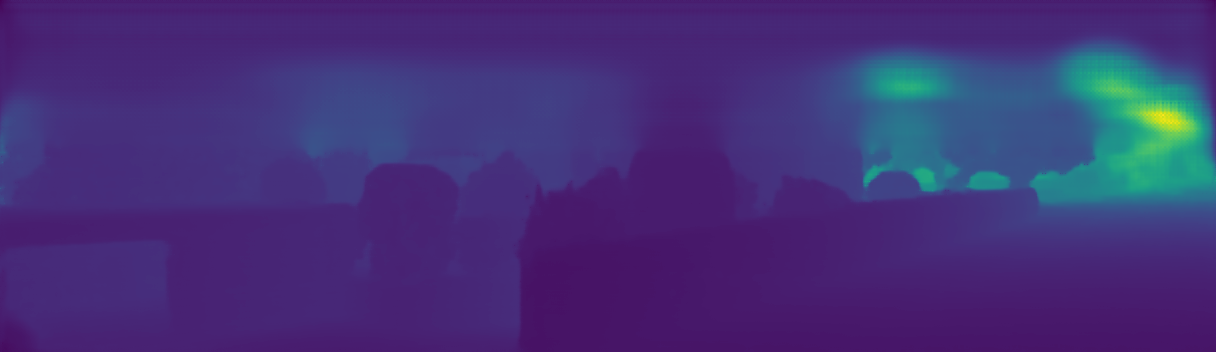

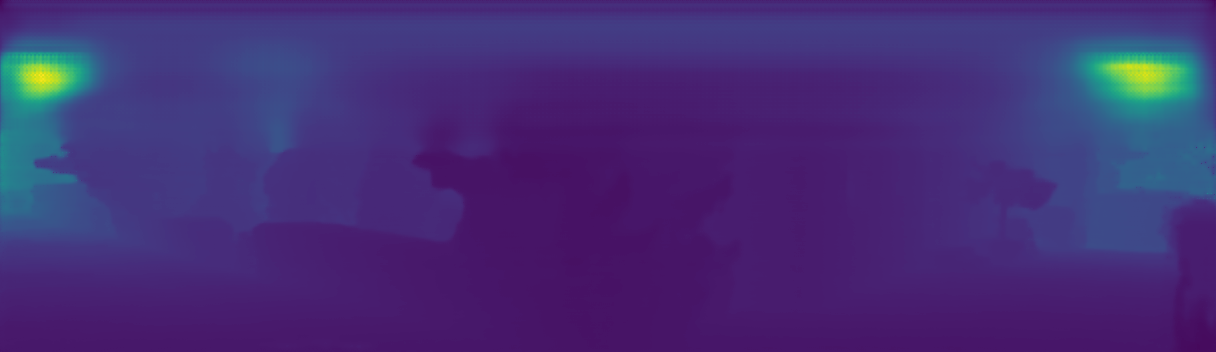

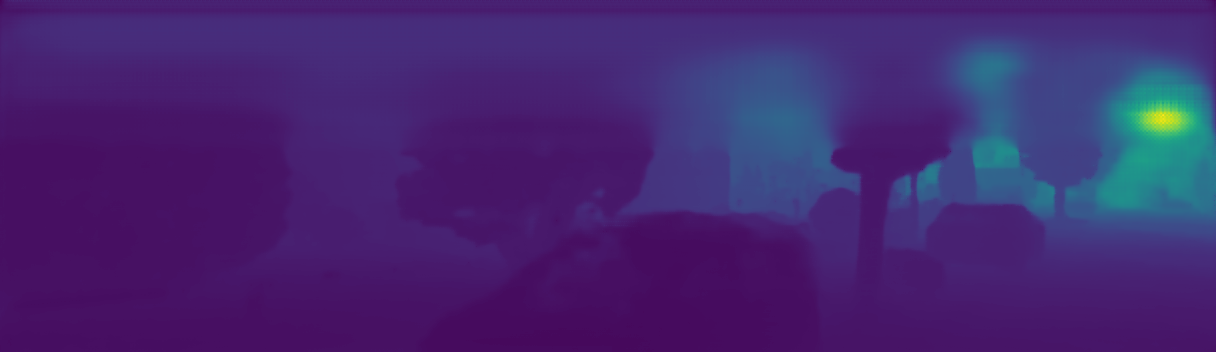

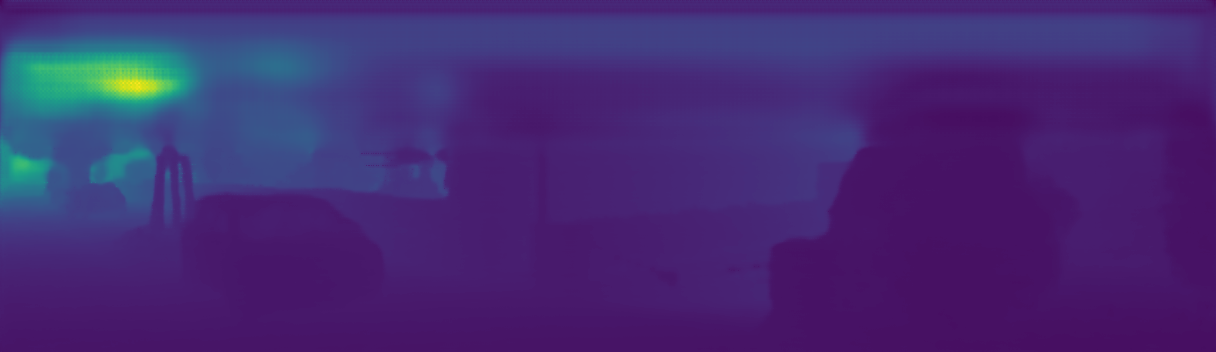

In [3]:
from depth_completion._2dpapenet import get_model as DepthCompletionModel
import torch

model = DepthCompletionModel(args).cuda()
model = model.load_from_checkpoint('./best_2dpapenet_detach.ckpt', args=args, strict=False).cuda()
with torch.no_grad():
    output_data = model(cur_data)

refine_img = output_data['refined_depth0'].data.cpu().numpy()
img = np.squeeze(refine_img/refine_img.max()*255.).astype(np.uint8)
img = color_range[img].astype(np.uint8)
imgsave = Image.fromarray(img)
imgsave.show()

refine_img = output_data['refined_depth1'].data.cpu().numpy()
img = np.squeeze(refine_img/refine_img.max()*255.).astype(np.uint8)
img = color_range[img].astype(np.uint8)
imgsave = Image.fromarray(img)
imgsave.show()

refine_img = output_data['refined_depth2'].data.cpu().numpy()
img = np.squeeze(refine_img/refine_img.max()*255.).astype(np.uint8)
img = color_range[img].astype(np.uint8)
imgsave = Image.fromarray(img)
imgsave.show()

refine_img = output_data['refined_depth3'].data.cpu().numpy()
img = np.squeeze(refine_img/refine_img.max()*255.).astype(np.uint8)
img = color_range[img].astype(np.uint8)
imgsave = Image.fromarray(img)
imgsave.show()

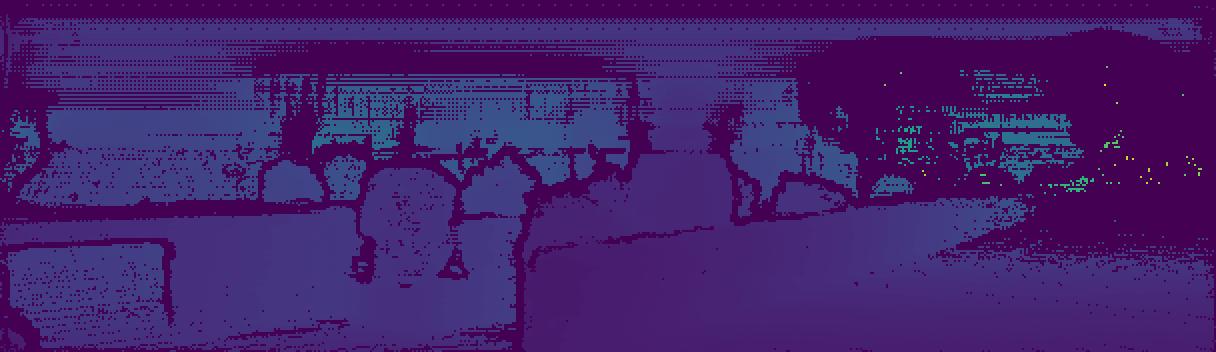

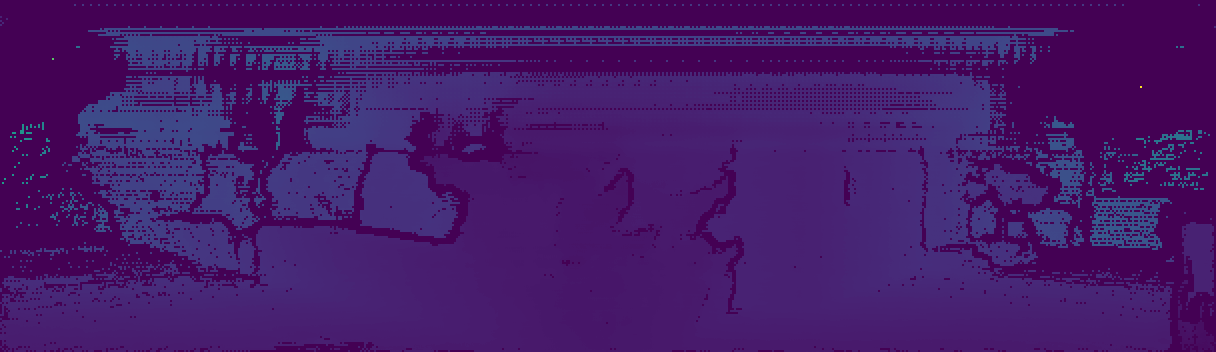

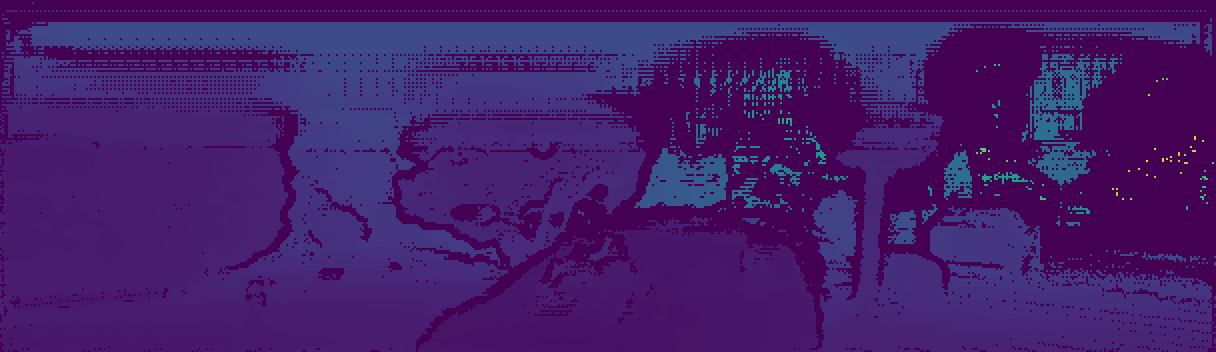

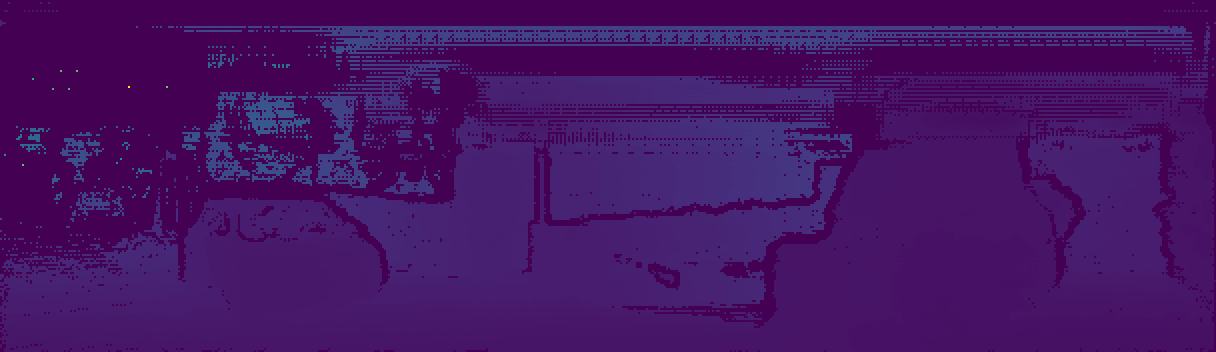

In [4]:
for i in range(4):
    refine_img = output_data['refined_depth'+str(i)]
    unfold_op = torch.nn.Unfold(2, stride=2)
    fold_op = torch.nn.Fold((refine_img.shape[-2], refine_img.shape[-1]), 2, stride=2)
    refine_edge = unfold_op(refine_img).permute(0, 2, 1).contiguous()
    top_num, _ = refine_edge.topk(1, dim=2, largest=True)
    bottom_num, _ = refine_edge.topk(1, dim=2, largest=False)
    mask = (top_num - bottom_num > 0.2).squeeze(-1)
    refine_edge[mask] = 0
    refine_img = fold_op(refine_edge.permute(0,2,1).contiguous())
    output_data['refined_depth'+str(i)] = refine_img

    refine_img = refine_img.cpu().numpy()
    img = np.squeeze(refine_img/refine_img.max()*255.).astype(np.uint8)
    img = color_range[img].astype(np.uint8)
    imgsave = Image.fromarray(img)
    imgsave.show()

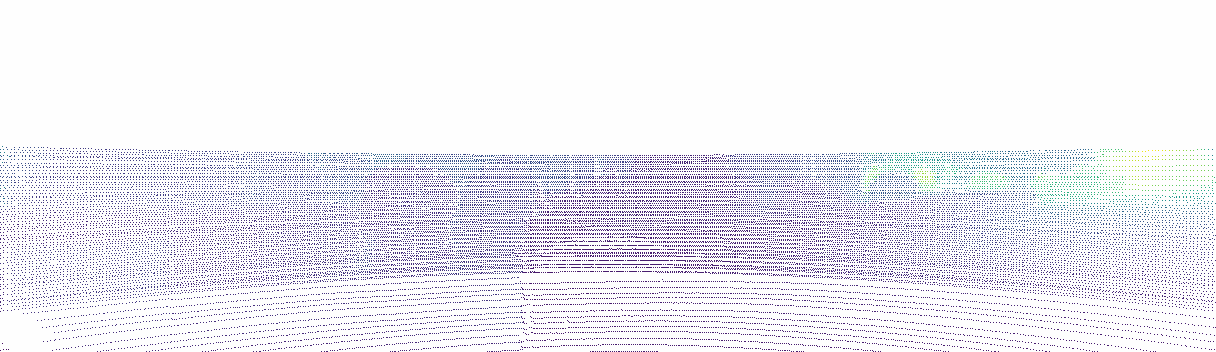

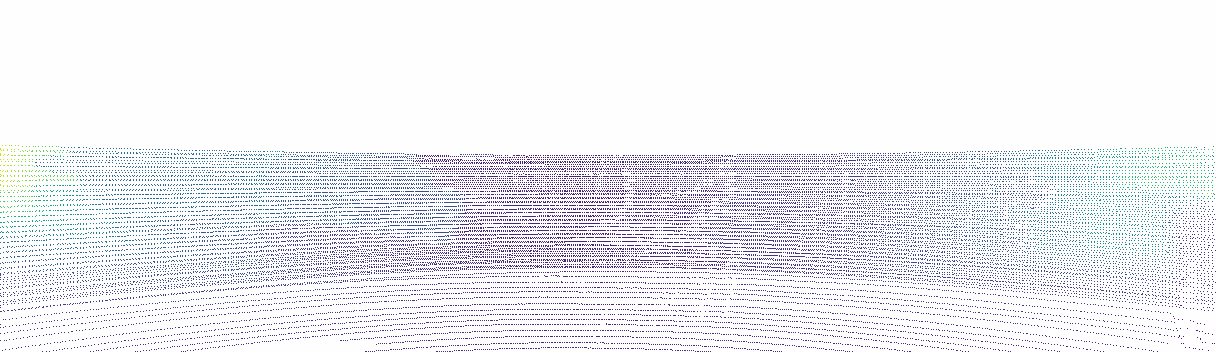

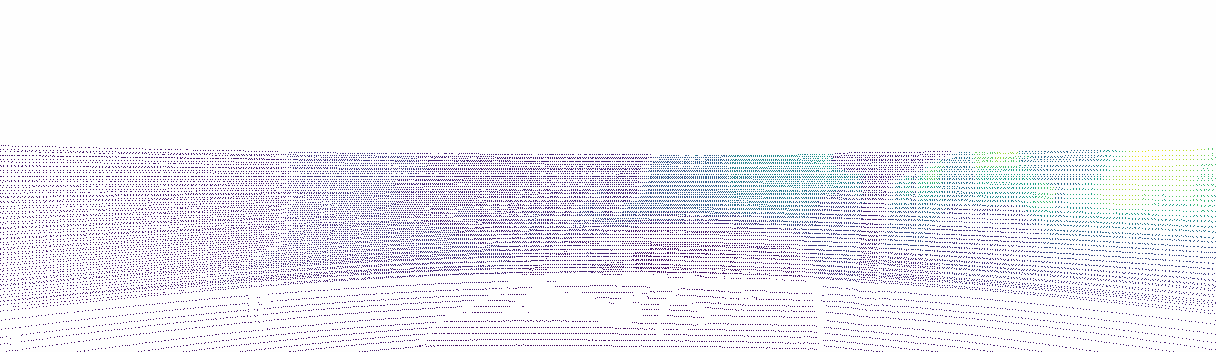

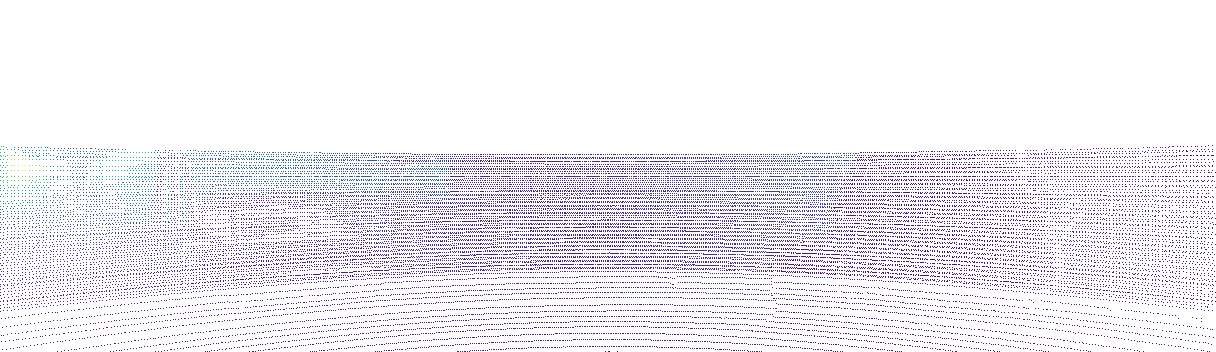

In [5]:
H = output_data['velodyne_proj_img0'].shape[2]
W = output_data['velodyne_proj_img0'].shape[3]
dense_coord = output_data['denser_coordinate'][0]
for i in range(4):
    sparse_img = output_data['velodyne_proj_img'+str(i)][0].permute(1, 2, 0).cpu().numpy().squeeze()
    max_dist = sparse_img.max()
    dense_img = output_data['refined_depth'+str(i)][0]
    # dense_img[dense_img > max_dist] = 0
    # output_data['refined_depth'+str(i)][0] = dense_img
    dense_img = dense_img.permute(1, 2, 0).cpu().detach().numpy().squeeze()
    sparse_img[dense_coord[:, 1], dense_coord[:, 0]] = dense_img[dense_coord[:, 1], dense_coord[:, 0]]

    transparency = np.ones_like(sparse_img)
    transparency[sparse_img>0]=255
    sparse_img = (sparse_img - sparse_img.min()) / (sparse_img.max() - sparse_img.min()) * 255.
    sparse_img = color_range[sparse_img.astype(np.uint8)].astype(np.uint8)
    sparse_img = np.concatenate([sparse_img,np.expand_dims(transparency,-1).astype(np.uint8)], axis=-1)
    denser_img = Image.fromarray(sparse_img)
    denser_img.show()

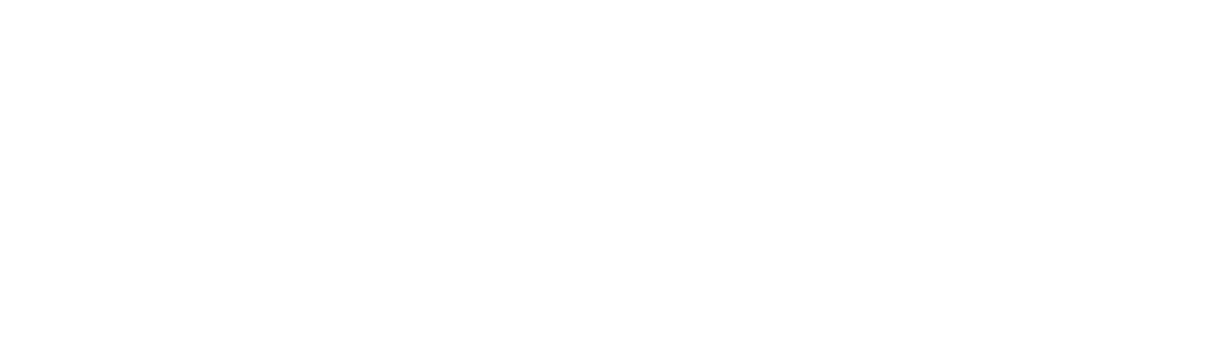

In [6]:
show_mask = np.zeros((H, W, 4)).astype(np.uint8)
mask_coord = output_data['denser_coordinate'].cpu().numpy().squeeze()
show_mask[mask_coord[:, 1], mask_coord[:, 0], 3] = 255
show_mask[mask_coord[:, 1], mask_coord[:, 0], 0] = 255
show_mask[mask_coord[:, 1], mask_coord[:, 0], 1] = 255
show_mask[mask_coord[:, 1], mask_coord[:, 0], 2] = 255
show_mask = Image.fromarray(show_mask)
show_mask.show()


In [7]:
denser_coordinate = [lines.cpu().numpy().squeeze() for lines in output_data['denser_coordinate_lines']]
sparse_proj_points = [points.cpu().numpy().squeeze() for points in output_data['sparse_proj_points']]
K = output_data['K'].cpu().numpy().squeeze()
T_velo2img = output_data['T_velo2img'].cpu().numpy().squeeze()[:3, :3]
T_4img = output_data['T_4img'].cpu().numpy().squeeze()[:3, :3]
T_rot = output_data['T_rot'].cpu().numpy().squeeze()[:3, :3]

K_inv = K[:3, :3]
K_inv = np.linalg.inv(K_inv)
T_velo2img_inv = np.linalg.inv(T_velo2img)
T_4img_inv = np.linalg.inv(T_4img)
# T_rot_inv = np.identity(3)
T_rot_inv = np.linalg.inv(T_rot)

print(len(denser_coordinate))
for i in range(len(denser_coordinate)):
    insert_coords = denser_coordinate[i]
    cat_ones = np.ones((insert_coords.shape[0], 1))
    all_insert_proj_points = []
    for img_idx in range(4):
        # -pi/4  pi/4
        dense_img = output_data['refined_depth'+str(img_idx)][0].permute(1, 2, 0).cpu().detach().numpy().squeeze()
        z_axis = dense_img[insert_coords[:, 1], insert_coords[:, 0]]
        z_axis = np.expand_dims(z_axis, -1)
        insert_proj_points = np.concatenate([insert_coords, cat_ones], axis=1)
        insert_proj_points = (K_inv @ insert_proj_points.T).T * z_axis
        mask = insert_proj_points[:, 2] > 0
        insert_proj_points = insert_proj_points[mask]
        insert_proj_points = (T_velo2img_inv @ insert_proj_points.T).T
        for rot_idx in range(img_idx):
            insert_proj_points = (T_4img_inv @ insert_proj_points.T).T
        insert_proj_points = (T_rot_inv @ insert_proj_points.T).T
        all_insert_proj_points.append(insert_proj_points)

    all_insert_proj_points = np.concatenate(all_insert_proj_points, axis=0)
    # print(insert_proj_points.shape)
    # print(insert_proj_points3.shape)
    # sparse_proj_points.insert(i, insert_proj_points)
    # sparse_proj_points.append(insert_proj_points)
    sparse_proj_points.insert(2 * i + 1, all_insert_proj_points)
    # print(insert_proj_points.shape)

sparse_proj_points = np.concatenate(sparse_proj_points, axis=0)
print(len(sparse_proj_points))
print(output_data['proj_points'].size)

cat_ones = np.ones((sparse_proj_points.shape[0], 1))
sparse_proj_points = np.concatenate([sparse_proj_points, cat_ones], axis=1).astype(np.float32)
T_xyz = output_data['T_xyz']
T_xyz_inv = np.linalg.inv(T_xyz)
sparse_proj_points = (T_xyz_inv @ sparse_proj_points.T).T.astype(np.float32)
max_range = output_data['distance'].numpy().max()
new_range = np.linalg.norm(sparse_proj_points, axis=1).astype(np.float32)
mask = (new_range<max_range).repeat(4, axis=1)
sparse_proj_points = sparse_proj_points[mask]
sparse_proj_points.tofile('./bin/denserpc.bin')

32
190337
<built-in method size of Tensor object at 0x7fa89d6cf400>


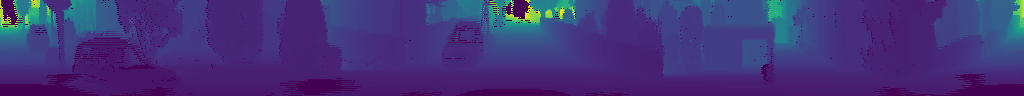

In [8]:
from projection.laserscan import LaserScan
import argparse
from torchvision.transforms import transforms
import numpy as np
from matplotlib import cm
import yaml
args = argparse.ArgumentParser("test")
args.add_argument("--config", type=str, default= "./config/semantic-kitti.yaml")
args = args.parse_args(args=[])

with open(args.config) as config:
    CFG = yaml.safe_load(config)
color_dict = CFG['color_map']
topil = transforms.ToPILImage()

# cmap = matplotlib.colormaps.get_cmap('viridis')
cmap = cm.get_cmap('viridis')
sm = cm.ScalarMappable(cmap=cmap)
color_range = sm.to_rgba(np.linspace(0,1,256), bytes=True)[:, 0:3]

laserscan = LaserScan(project=True, H=64+32)
scan_path = "./bin/denserpc.bin"
# scan_path = "/media/shitong/passport/SemanticKITTI/sequences/03/velodyne/000001.bin"
laserscan.open_scan(scan_path, scan_unfold=True)

range_img = laserscan.proj_range
range_img = ((range_img-range_img.min())/(range_img.max()-range_img.min())*255).astype(np.uint8)
range_img_color = color_range[range_img].astype(np.uint8)

range_img = topil(range_img_color)
range_img.show()

# laserscan = LaserScan(project=True, H=64)
# scan_path = "/root/autodl-tmp/SemanticKITTI/sequences/03/velodyne/000000.bin"
# laserscan.open_scan(scan_path, scan_unfold=True)

# range_img = laserscan.proj_range
# range_img = ((range_img-range_img.min())/(range_img.max()-range_img.min())*255).astype(np.uint8)
# range_img_color = color_range[range_img].astype(np.uint8)

# range_img = topil(range_img_color)
# range_img.show()


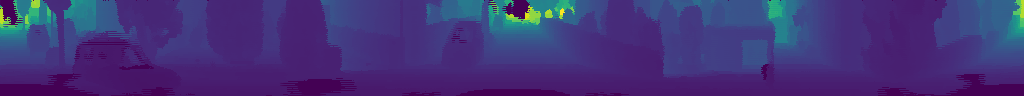

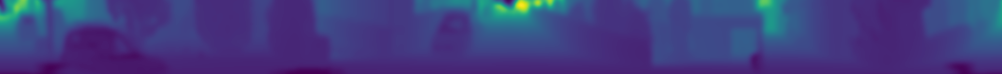

In [9]:
from pcm.proximity_convolution import proximity_conv
from torch.nn import Conv2d
from torch.nn.parameter import Parameter
import torch
totensor = transforms.ToTensor()
p_conv = proximity_conv(1, 1, 3, stride=1)
p_conv.pconv_weight = Parameter(torch.ones(1,1,3,3)/9.)
n_conv = Conv2d(1, 1, 3, stride=1)
n_conv.weight = Parameter(torch.ones(1,1,3,3)/9.)
p_conv_input = totensor(laserscan.proj_range).unsqueeze(0)
n_conv_input = totensor(laserscan.proj_range).unsqueeze(0)
for i in range(10):
    p_conv_input = p_conv(p_conv_input)
    n_conv_input = n_conv(n_conv_input)
p_conv_result = p_conv(p_conv_input)[0].permute(1,2,0).detach().numpy()[:,:,0]
n_conv_result = n_conv(n_conv_input)[0].permute(1,2,0).detach().numpy()[:,:,0]
p_conv_img = ((p_conv_result - p_conv_result.min())/(p_conv_result.max()-p_conv_result.min())*255).astype(np.uint8)
n_conv_img = ((n_conv_result - n_conv_result.min())/(n_conv_result.max()-n_conv_result.min())*255).astype(np.uint8)
p_conv_color = color_range[p_conv_img]
n_conv_color = color_range[n_conv_img]

p_conv_color = topil(p_conv_color)
n_conv_color = topil(n_conv_color)
p_conv_color.show()
n_conv_color.show()